In [1]:
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.externals import joblib
from sklearn.model_selection import (GridSearchCV, train_test_split, KFold,
                                     cross_val_score)
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import (CountVectorizer, TfidfTransformer, TfidfVectorizer)

#### TfidfVectorizer == CountVectorizer + TfidfTransformer

In [3]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline

# Models

In [4]:
from xgboost import XGBClassifier

from sklearn.linear_model import PassiveAggressiveClassifier, RidgeClassifierCV, SGDClassifier,LogisticRegressionCV                                 
from sklearn.ensemble import (AdaBoostClassifier,BaggingClassifier,ExtraTreesClassifier,
                              GradientBoostingClassifier,RandomForestClassifier)                               
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

In [5]:
from helper import (load_data, token,time_me,
                    show_diagram, show_most_informative_features)

In [6]:
import warnings
warnings.simplefilter(action='ignore', category=(UserWarning,FutureWarning))

In [7]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight') # plt.style.available

In [8]:
stops = joblib.load('../stops.pkl')

Loading data ...
Droping 10 rows with features lenght of less than 2
Droping 3 as rating and setting 1-2 as negative(0), 4-5 as positive(1))
{1: 460527, 0: 127232} 

Down sampling positive ratings to match negatives
Data loading completed
{1: 127232, 0: 127232} 

Execution Time: 7 seconds


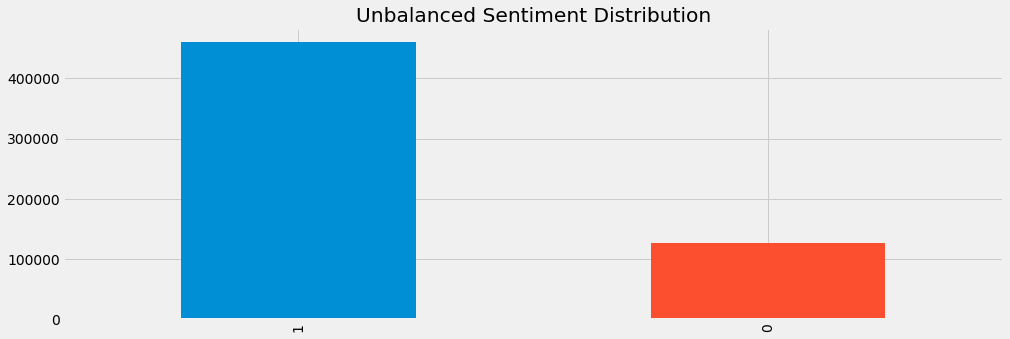

In [9]:
df = load_data('../sentiment_data', balanced=True)

In [10]:
df.head()

,features,target,y
0,Internetkøb med postleverance på under 24 time...,5,1
1,Let og hurtig behandling af erstatning. \r\nMe...,5,1
2,Venlig og hurtig betjening,5,1
3,Super hurtig og effektiv forsendelse lige til ...,5,1
4,"Nemt at bestille, hurtig levering og varen er ...",5,1


In [11]:
 X_train, X_test, y_train, y_test = train_test_split(df['features'], df['y'],
                                                    test_size=.2, random_state=7,stratify=df['y'])

In [12]:
print(f'Traing Size: {X_train.shape[0]}\nTest Size: {X_test.shape[0]:>8}')

Traing Size: 203571
Test Size:    50893


In [13]:
print(f'Traing Size\n\tPositive||Negative Sample\n\t  {y_train[y_train==1].shape[0]}||{y_train[y_train==0].shape[0]}')

Traing Size
	Positive||Negative Sample
	  101785||101786


In [14]:
print(f'Test Size\n\tPositive||Negative Sample\n\t  {y_test[y_test==1].shape[0]}||{y_test[y_test==0].shape[0]}')

Test Size
	Positive||Negative Sample
	  25447||25446


In [15]:
def model_test(model, bench_mark):
    
    clf = Pipeline(steps=[
                         ('vec',  CountVectorizer(ngram_range=(1, 2), max_features=100000,
                                 tokenizer=token, stop_words=stops)),
                        ('fe_se', SelectKBest(chi2, k=5000)),
                        ('tfidf', TfidfTransformer(sublinear_tf=True)),
                        ('classifier', model),
                ])
    print(f'Model Training {clf.steps[3][1].__class__.__name__}')
    print(f'params:{clf.steps[3][1].get_params()}')
    print('-'*15)
    
    try:
        train_start_time = pd.datetime.now()
        clf.fit(X_train,y_train)
        train_duration = pd.datetime.now() - train_start_time
        
        test_start_time = pd.datetime.now()
        score = clf.score(X_test,y_test)
        test_duration = pd.datetime.now() - test_start_time

        print(f'Training duration: {train_duration}')
        print(f'Testing duration: {test_duration}')
        print(f'Model Score: {score}')
        print('*'*15,'\n')



        bench_mark['model_name'].append(clf.steps[3][1].__class__.__name__)
        bench_mark['model'].append(clf.steps[3][1])
        bench_mark['score'].append(clf.score(X_test,y_test))
        bench_mark['train_duration'].append(train_duration.total_seconds())
        bench_mark['test_duration'].append(test_duration.total_seconds())
        bench_mark['params'].append(clf.steps[3][1].get_params())

        try:
            show_diagram(clf, X_train, y_train, X_test, y_test, compare_test=True)
        except Exception as e:
            print(f'failed to show diagram: {e}')
            pass
        
    except Exception as m:
        print(f'Training failed with {m}')
        pass
    
    return bench_mark

In [16]:
linear_models = [PassiveAggressiveClassifier(max_iter=1000, random_state=0,tol=1e-3), 
                 PassiveAggressiveClassifier(C=1e-1,max_iter=1e3,  tol=1e3), 
                 RidgeClassifierCV(scoring='roc_auc', cv=10),
                 LogisticRegressionCV(cv=5,solver='saga',scoring='accuracy', n_jobs=-1),
                 SGDClassifier(loss='log', random_state=1, max_iter=1),
                 
                ]

ensemble_models = [AdaBoostClassifier(n_estimators=100,learning_rate=.01,),
                   ExtraTreesClassifier(criterion='gini',  min_samples_split=5,),
                   ExtraTreesClassifier(criterion='entropy',  min_samples_split=5,),
                   GradientBoostingClassifier(max_depth=5),
                   RandomForestClassifier(),
                   RandomForestClassifier(criterion='entropy'),
                  ]
tree_models = [DecisionTreeClassifier(),
              ExtraTreeClassifier()
             ]


In [17]:
# GradientBoosting

parameters = {
    'loss':['deviance','exponential'],
    'learning_rate': [0.01, 0.05, 0.1],
    'min_samples_split': np.linspace(0.1, 0.5, 12),
    'min_samples_leaf': np.linspace(0.1, 0.5, 12),
    'max_depth':[3,5,8],
    'max_features':['log2','sqrt'],
    'criterion': ['friedman_mse',  'mae'],
    'subsample':[0.5, 0.8, 1.0],
    'n_estimators':[10]
    }

In [18]:
xgb_para = dict(booster = 'dart',
                learning_rate =0.03,
                 n_estimators=100,
                 max_depth=3,
                 min_child_weight=1,
                 gamma=0,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 objective= 'binary:logistic',
                 nthread=4,
                 scoring='error',            
                 scale_pos_weight=1,
                 silent=True,
                 seed=42)

In [19]:
final_models = [GridSearchCV(GradientBoostingClassifier(), parameters,scoring='roc_auc', cv=10, n_jobs=-1, verbose=1),
                XGBClassifier(**xgb_para),]

Model Training PassiveAggressiveClassifier
params:{'C': 1.0, 'average': False, 'class_weight': None, 'early_stopping': False, 'fit_intercept': True, 'loss': 'hinge', 'max_iter': 1000, 'n_iter': None, 'n_iter_no_change': 5, 'n_jobs': None, 'random_state': 0, 'shuffle': True, 'tol': 0.001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
---------------
Training duration: 0:01:08.360756
Testing duration: 0:00:12.632251
Model Score: 0.9255496826675574
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.93      0.92      0.92     25446
    Positive       0.92      0.93      0.93     25447

   micro avg       0.93      0.93      0.93     50893
   macro avg       0.93      0.93      0.93     50893
weighted avg       0.93      0.93      0.93     50893

	 _____________________________________________ 


failed to show diagram: 'PassiveAggressiveClassifier' object has no

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

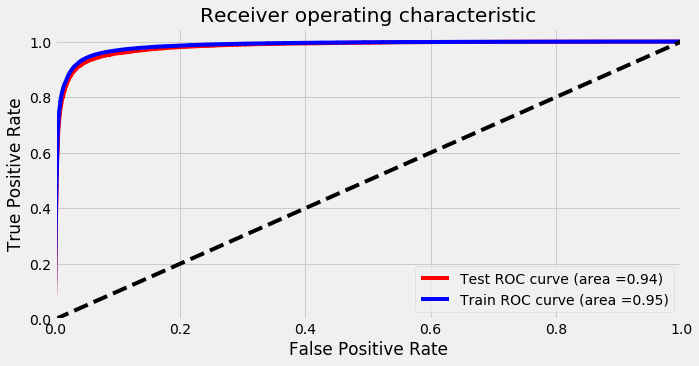

Execution Time: 3 minutes and 17 seconds
Model Training SGDClassifier
params:{'alpha': 0.0001, 'average': False, 'class_weight': None, 'early_stopping': False, 'epsilon': 0.1, 'eta0': 0.0, 'fit_intercept': True, 'l1_ratio': 0.15, 'learning_rate': 'optimal', 'loss': 'log', 'max_iter': 1, 'n_iter': None, 'n_iter_no_change': 5, 'n_jobs': None, 'penalty': 'l2', 'power_t': 0.5, 'random_state': 1, 'shuffle': True, 'tol': None, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
---------------
Training duration: 0:01:03.180476
Testing duration: 0:00:12.393477
Model Score: 0.9235651268347317
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.90      0.95      0.93     25446
    Positive       0.95      0.90      0.92     25447

   micro avg       0.92      0.92      0.92     50893
   macro avg       0.92      0.92      0.92     50893
weighted avg       0.92      0.92    

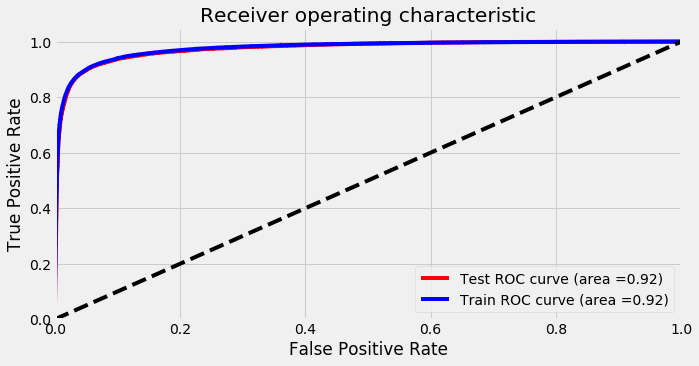

Execution Time: 3 minutes and 18 seconds
Model Training AdaBoostClassifier
params:{'algorithm': 'SAMME.R', 'base_estimator': None, 'learning_rate': 0.01, 'n_estimators': 100, 'random_state': None}
---------------
Training duration: 0:02:43.002766
Testing duration: 0:00:13.336393
Model Score: 0.7799893895034681
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.87      0.66      0.75     25446
    Positive       0.73      0.90      0.80     25447

   micro avg       0.78      0.78      0.78     50893
   macro avg       0.80      0.78      0.78     50893
weighted avg       0.80      0.78      0.78     50893

	 _____________________________________________ 




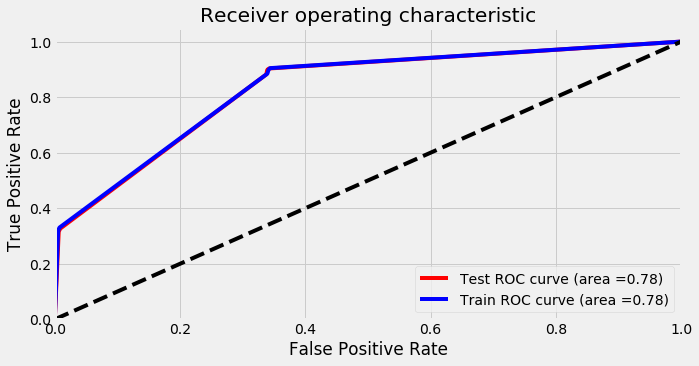

Execution Time: 3 minutes and 29 seconds
Model Training ExtraTreesClassifier
params:{'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
---------------
Training duration: 0:02:48.306181
Testing duration: 0:00:12.714599
Model Score: 0.9218556579490303
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.90      0.95      0.92     25446
    Positive       0.95      0.89      0.92     25447

   micro avg       0.92      0.92      0.92     50893
   macro avg       0.92      0.92      0.92     50893
weighted avg       0.92      0.92      0.92     50893



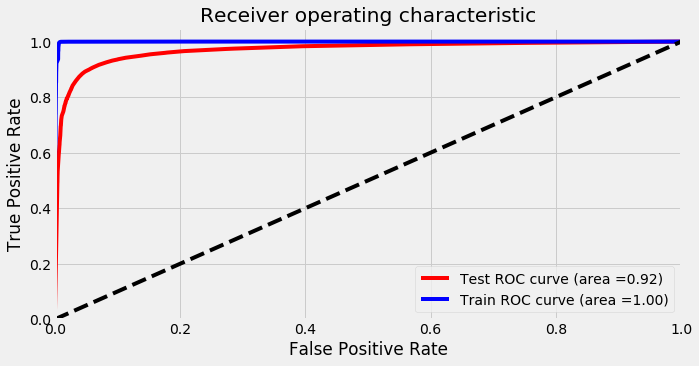

Execution Time: 3 minutes and 26 seconds
Model Training ExtraTreesClassifier
params:{'bootstrap': False, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
---------------
Training duration: 0:02:58.285444
Testing duration: 0:00:12.667980
Model Score: 0.9220717976931995
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.90      0.95      0.92     25446
    Positive       0.95      0.89      0.92     25447

   micro avg       0.92      0.92      0.92     50893
   macro avg       0.92      0.92      0.92     50893
weighted avg       0.92      0.92      0.92     5089

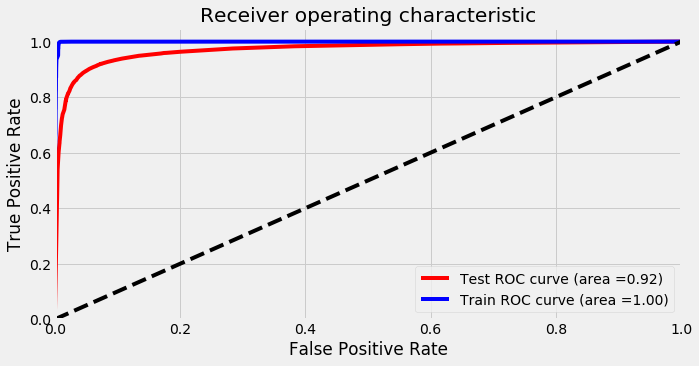

Execution Time: 3 minutes and 27 seconds
Model Training GradientBoostingClassifier
params:{'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 5, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': None, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}
---------------
Training duration: 0:07:00.040019
Testing duration: 0:00:12.357181
Model Score: 0.9003006307350716
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.91      0.89      0.90     25446
    Positive       0.89      0.91      0.90     25447

   micro avg       0.90      0.90      0.90     50893
   macro avg       

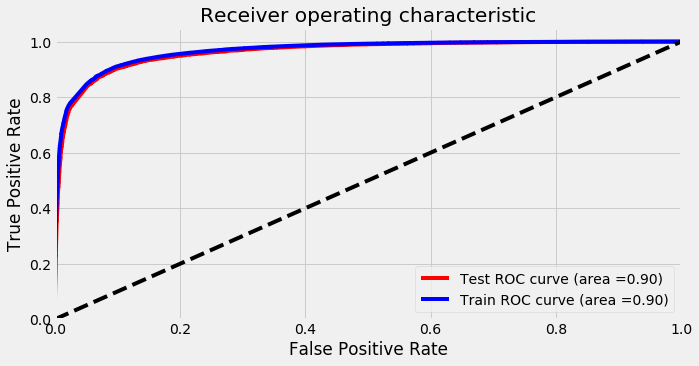

Execution Time: 3 minutes and 22 seconds
Model Training RandomForestClassifier
params:{'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
---------------
Training duration: 0:02:37.974595
Testing duration: 0:00:12.710503
Model Score: 0.9128563849645335
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.89      0.94      0.92     25446
    Positive       0.94      0.88      0.91     25447

   micro avg       0.91      0.91      0.91     50893
   macro avg       0.91      0.91      0.91     50893
weighted avg       0.91      0.91      0.91     50893


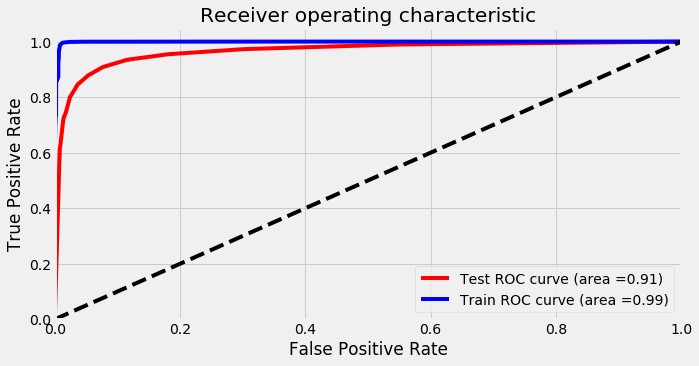

Execution Time: 3 minutes and 26 seconds
Model Training RandomForestClassifier
params:{'bootstrap': True, 'class_weight': None, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 'warn', 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
---------------
Training duration: 0:02:45.659135
Testing duration: 0:00:12.949011
Model Score: 0.9138584874147722
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.89      0.95      0.92     25446
    Positive       0.94      0.88      0.91     25447

   micro avg       0.91      0.91      0.91     50893
   macro avg       0.92      0.91      0.91     50893
weighted avg       0.92      0.91      0.91     508

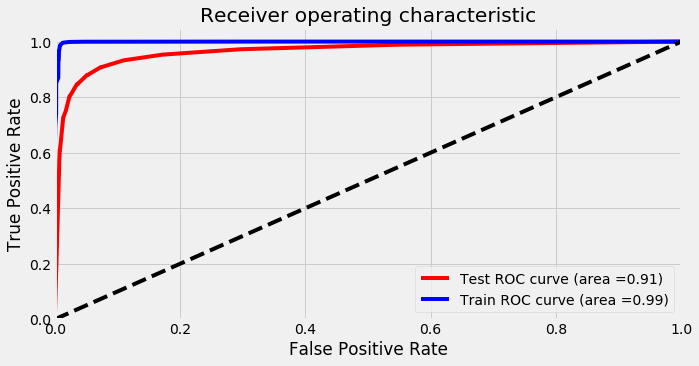

Execution Time: 3 minutes and 23 seconds
Model Training DecisionTreeClassifier
params:{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
---------------
Training duration: 0:04:43.275853
Testing duration: 0:00:12.419935
Model Score: 0.8891006621735799
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.89      0.88      0.89     25446
    Positive       0.89      0.89      0.89     25447

   micro avg       0.89      0.89      0.89     50893
   macro avg       0.89      0.89      0.89     50893
weighted avg       0.89      0.89      0.89     50893

	 _____________________________________________ 




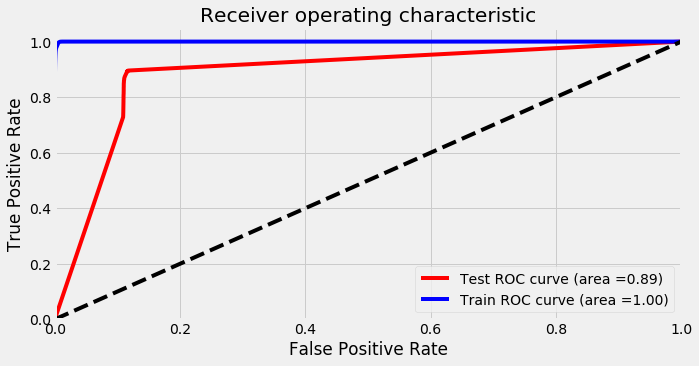

Execution Time: 3 minutes and 19 seconds
Model Training ExtraTreeClassifier
params:{'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': None, 'splitter': 'random'}
---------------
Training duration: 0:01:14.071846
Testing duration: 0:00:12.401202
Model Score: 0.8651680977737606
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.87      0.86      0.86     25446
    Positive       0.86      0.87      0.87     25447

   micro avg       0.87      0.87      0.87     50893
   macro avg       0.87      0.87      0.87     50893
weighted avg       0.87      0.87      0.87     50893

	 _____________________________________________ 




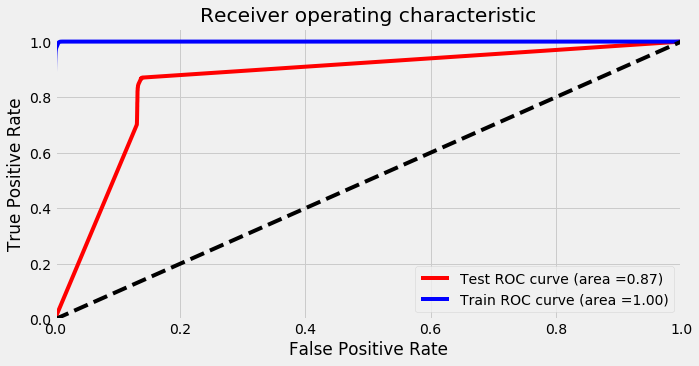

Execution Time: 3 minutes and 19 seconds
Model Training GridSearchCV
params:{'cv': 10, 'error_score': 'raise-deprecating', 'estimator__criterion': 'friedman_mse', 'estimator__init': None, 'estimator__learning_rate': 0.1, 'estimator__loss': 'deviance', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__max_leaf_nodes': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_iter_no_change': None, 'estimator__presort': 'auto', 'estimator__random_state': None, 'estimator__subsample': 1.0, 'estimator__tol': 0.0001, 'estimator__validation_fraction': 0.1, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 14.9min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed: 26.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 41.7min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 59.9min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 81.2min
[Parallel(n_jobs=-1)]: Done 3192 tasks      | elapsed: 106.0min
[Parallel(n_jobs=-1)]: Done 4042 tasks      | elapsed: 133.9min
[Parallel(n_jobs=-1)]: Done 4992 tasks      | elapsed: 165.5min
[Parallel(n_jobs=-1)]: Done 6042 tasks      | elapsed: 200.2min
[Parallel(n_jobs=-1)]: Done 7192 tasks      | elapsed: 238.4min
[Parallel(n_jobs=-1)]: Done 8442 tasks      | elapsed: 279.7min
[Parallel(n_jobs=-1)]: Done 9792 tasks      | elapsed: 323.8min
[Parallel(n_jobs=-1)]: Done 11242 tasks

Training failed with Could not pickle the task to send it to the workers.
Model Training XGBClassifier
params:{'base_score': 0.5, 'booster': 'dart', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.03, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': 4, 'objective': 'binary:logistic', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 42, 'silent': True, 'subsample': 0.8, 'scoring': 'error'}
---------------
Training duration: 0:02:07.626089
Testing duration: 0:00:19.858542
Model Score: 0.8476411294284086
*************** 

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.87      0.82      0.84     25446
    Positive       0.83      0.88      0.85     25447

   micro avg       0.85      0.85      0.85     50893
   macro avg       0.85      0.85      0.85     

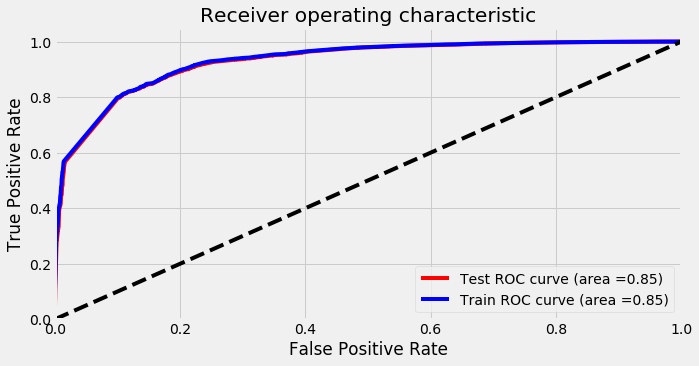

Execution Time: 4 minutes and 13 seconds


In [20]:
bench_mark = defaultdict(list)
models = linear_models + ensemble_models + tree_models + final_models
for model in models:
    model_test(model,bench_mark)

In [21]:
pd.DataFrame(bench_mark).to_pickle('models_wars.pkl')

In [ ]:
# feature_names = lr_clf.steps[0][1].get_feature_names()

# best_features = [feature_names[i] for i in lr_clf.steps[1][1].get_support(indices=True)]

# show_most_informative_features(best_features, lr_clf.steps[3][1], n=100)